In [1]:
import os
import sys
import umap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse

sys.path.insert(0, "..")
from utils import load_all, get_dataset_names, get_dip_sequence
from utils import RESULTSPATH

/home/jens/anaconda3/envs/dips/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and preprocessing

In [2]:
dfnames = get_dataset_names(cutoff=40)
dfs, _ = load_all(dfnames, expected=False)

## Sequence clustering

In [3]:
def wrap_get_dip_sequence(row):
    s, _, _ = get_dip_sequence(row["key"], row["Strain"])
    return s

modified_dfs = list()
for df, dfname in zip(dfs, dfnames):
    df["dip_seq"] = df.apply(wrap_get_dip_sequence, axis=1)
    df = df.drop(columns=["isize", "full_seq", "deleted_sequence", "seq_around_deletion_junction"])
    df["name"] = dfname
    modified_dfs.append(df)

comb_df = pd.concat(modified_dfs, ignore_index=True)

In [ ]:
CHARS = "ACGU*"
CHARS_COUNT = len(CHARS)
MAX_LEN = 2400


def full_sequence_ohe(df: pd.DataFrame):
    # defining initializing matrix
    n = df.shape[0]
    res = np.zeros((n, CHARS_COUNT * MAX_LEN), dtype=np.uint8)

    # getting sequence window for each row and do OHE
    for i, r in df.iterrows():
        seq = r["dip_seq"]
        seq = seq + "*" * (MAX_LEN - len(seq))
        # Write down OHE in numpy array
        for j, char in enumerate(seq):
            pos = CHARS.rfind(char)
            res[i][j*CHARS_COUNT+pos] = 1

    # format as data frame and create columns names of OHE
    encoded_df = pd.DataFrame(res)
    col_names = [f"{i}_{ch}" for i in range(1, MAX_LEN+1) for ch in CHARS]
    encoded_df.columns = col_names
    df = df.join(encoded_df)

    return df, col_names

one_hot_encoded_df, col_names = full_sequence_ohe(comb_df)

## Create UMAP to visualize in 2D

In [5]:
umap_obj = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_obj.fit_transform(one_hot_encoded_df[col_names])
umap_df = pd.DataFrame(data=umap_result, columns=["UMAP1", "UMAP2"])
full_df = pd.concat([comb_df, umap_df], axis=1)

/home/jens/anaconda3/envs/dips/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [6]:
def plot_per_feature(df, f):
    cmap = plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, len(df[f].unique())))
    
    plt.figure(figsize=(12,6))
    for i, col in enumerate(df[f].unique()):
        p_df = df[df[f] == col]
        plt.scatter(p_df["UMAP1"], p_df["UMAP2"], label=col, s=1, color=colors[i])
    
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), ncol=5, markerscale=5)
    plt.show()

## Visualize first results

The clustering is mainly by strain (img 2) and segment (img 3).

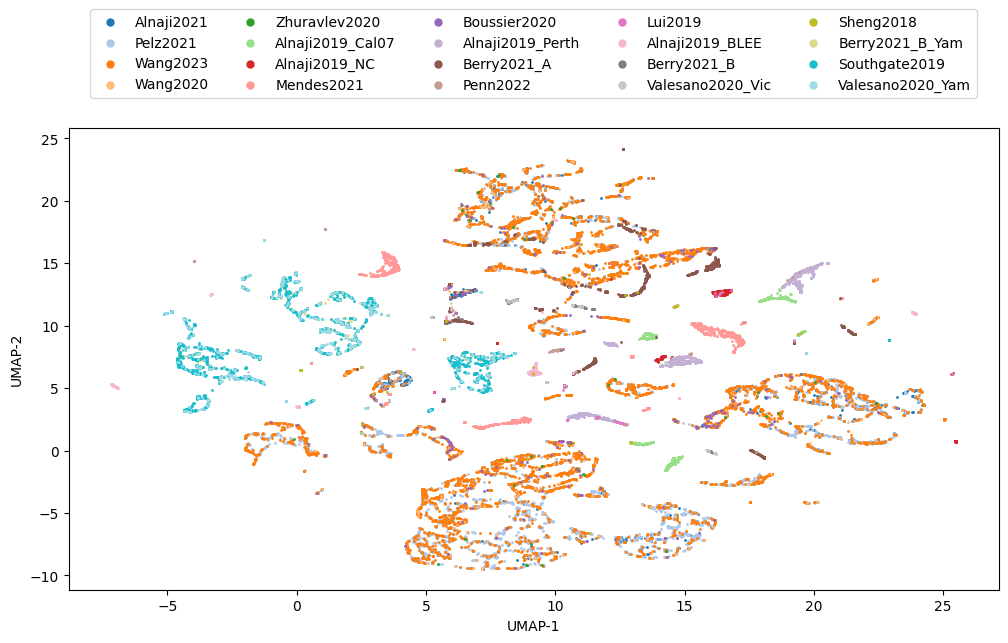

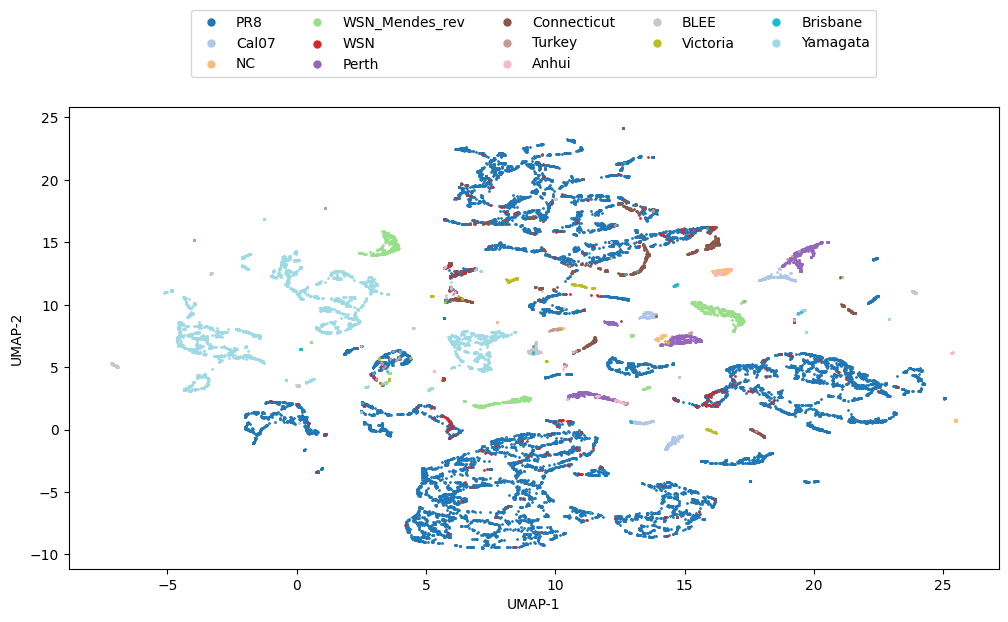

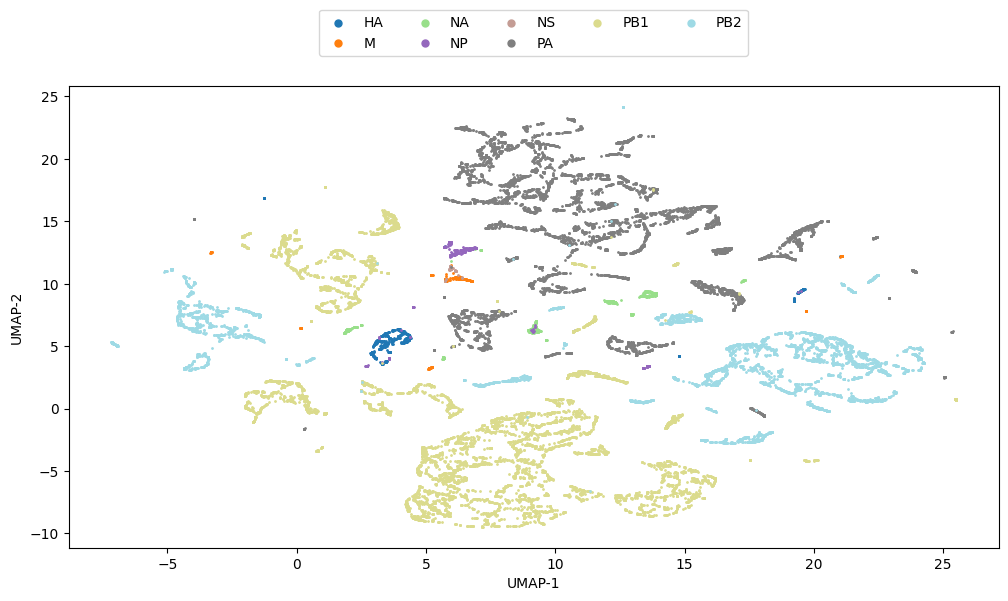

In [7]:
plot_per_feature(full_df, "name")
plot_per_feature(full_df, "Strain")
plot_per_feature(full_df, "Segment")

### Create final figure

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, 20))

for i, (df, dfname) in enumerate(zip(dfs, dfnames)):
    t_df = full_df[full_df["name"] == dfname]
    plt.scatter(t_df["UMAP1"], t_df["UMAP2"], label=dfname, s=2, alpha=1, color=colors[i])


color = "black"
ellipse = Ellipse((20, 3), width=9, height=8, angle=15, edgecolor=color, facecolor="none")
ax.add_patch(ellipse)
plt.text(17.8, -2.5, "A/Puerto Rico/8/1934, PB2", fontsize=12, color=color)

color = "black"
ellipse = Ellipse((10, -5), width=15, height=10, angle=0, edgecolor=color, facecolor="none")
ax.add_patch(ellipse)
plt.text(5, -11.5, "A/Puerto Rico/8/1934, PB1", fontsize=12, color=color)

color = "black"
ellipse = Ellipse((10.5, 18), width=13, height=10, angle=-45, edgecolor=color, facecolor="none")
ax.add_patch(ellipse)
plt.text(10, 24, "A/Puerto Rico/8/1934, PA", fontsize=12, color=color)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.23), ncol=5, markerscale=5)

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
fig.savefig(os.path.join(os.path.dirname(RESULTSPATH), "additional_analyses", "batch_effect_supplement_B.png"), dpi=300)
plt.close()